In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
names = open('names.txt','r').read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
#character mapping with integer
chrs = sorted(list(set(''.join(names))))
#char to integer
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.']=0
# index to chars
itos ={i:s for s,i in stoi.items()}


<h3>Building A dataset</h3>

In [4]:
block_size = 3
def building_dataset(names):
    X,Y =[],[]
    for n in names:
        context = [0] * block_size
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    
    X =torch.tensor(X)
    Y =torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr,Ytr = building_dataset(names[n1:])
Xval,Yval = building_dataset(names[n1:n2])
Xte,Yte = building_dataset(names[n2:])
        

<h3>Words Embedding, Forward and Backward<h3>

In [5]:
w1 = torch.rand(6,200) * (5/3)/(6**0.5)
"""When using batch normalization, instead of using b1 ,bnbias are in charege of distribution.
basically, batch normalization has its own bias no need to add ."""
b1 = torch.rand(200) * 0.1 
w2 = torch.rand(200,27) 
b2 = torch.rand(27) * 0 
g = torch.Generator().manual_seed(42)

bngain = torch.ones((1,200))
bnbias = torch.zeros((200))
bnmean_running = torch.zeros(1,200)
bnstd_running = torch.ones(1,200)



In [6]:
C = torch.rand(Xtr.shape[0],2)
params = [C,w1,w2,b2,bngain,bnbias]
for p in params:
    p.requires_grad = True

In [7]:
lossi = []
epsilon = 1e-6  # small constant to avoid division by zero
for _ in range(100):
    ix = torch.randint(0, Xtr.shape[0],(32,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]
    emb = C[Xb]
    #feed into the neurons
    embcat = emb.view(-1,6) # need to change shape to @
    hpre = embcat @ w1 #+ b1
    # batch normalization step
    
    bnstdi = hpre.std(0,keepdim=True)
    bnmeani = hpre.mean(0,keepdim=True)
    hpre = bngain * (hpre - bnmeani) /(bnstdi + epsilon) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    # create a fake count
    logits = hpre @ w2 + b2 
    loss = F.cross_entropy(logits,Yb)
    for p in params:
        p.grad = None
    #backward
    loss.backward()
    for p in params:
        p.data += -0.001 * p.grad
    print(loss.item())
    lossi.append(loss.log10().item())


3.4309792518615723
3.1861979961395264
3.3622701168060303
3.1932005882263184
3.3164029121398926
3.3242740631103516
3.255892038345337
3.246380567550659
3.269362449645996
3.3474984169006348
3.269620180130005
3.3362069129943848
3.5083582401275635
3.2697646617889404
3.2839744091033936
3.4269356727600098
3.287010669708252
3.228299617767334
3.228970766067505
3.5119307041168213
3.48305606842041
3.334850788116455
3.300046682357788
3.326765775680542
3.228118896484375
3.5321431159973145
3.12965989112854
3.2670178413391113
3.263434410095215
3.2558705806732178
3.2293922901153564
3.305126667022705
3.4294424057006836
3.351328134536743
3.4399490356445312
3.350193977355957
3.3844950199127197
3.2161898612976074
3.312751293182373
3.3900911808013916
3.340174674987793
3.329882860183716
3.2994511127471924
3.134699583053589
3.3261890411376953
3.18936824798584
3.438870906829834
3.3025076389312744
3.198887825012207
3.278268814086914
3.437732219696045
3.3288652896881104
3.2670679092407227
3.297567844390869
3.27

In [8]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' :(Xtr,Ytr),
        'val' : (Xval,Yval),
        'test': (Xte,Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpre = embcat @ w1 #+ b1
    hpre = bngain * (hpre - bnmean_running) /(bnstd_running) + bnbias    
    h = torch.tanh(hpre)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 4.609852313995361
val 4.6012187004089355


In [9]:
# plt.hist(h.view(-1).tolist(),50)

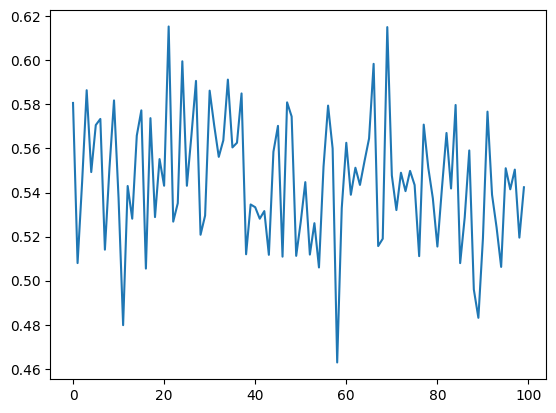

In [88]:

plt.plot(lossi)

In [89]:
hpre.shape

torch.Size([32, 200])

(array([  64.,    0.,    0.,    0.,    0.,   64.,   64.,    0.,    0.,
           0.,    0.,   32., 1056.,    0.,    0.,   32.,    0.,    0.,
         832.,   96.,    0.,   32.,    0.,    0.,  992.,  544.,    0.,
          32.,   64.,    0.,  480.,  704.,    0.,    0.,   32.,    0.,
         160.,  832.,   32.,    0.,    0.,    0.,    0.,  192.,   32.,
           0.,    0.,    0.,    0.,   32.]),
 array([-0.47554204, -0.45644804, -0.43735404, -0.41826004, -0.39916604,
        -0.38007204, -0.36097804, -0.34188404, -0.32279004, -0.30369604,
        -0.28460204, -0.26550804, -0.24641404, -0.22732004, -0.20822604,
        -0.18913204, -0.17003804, -0.15094404, -0.13185004, -0.11275604,
        -0.09366204, -0.07456804, -0.05547404, -0.03638004, -0.01728604,
         0.00180796,  0.02090196,  0.03999596,  0.05908996,  0.07818396,
         0.09727796,  0.11637196,  0.13546596,  0.15455996,  0.17365396,
         0.19274796,  0.21184196,  0.23093596,  0.25002996,  0.26912396,
         0.28821

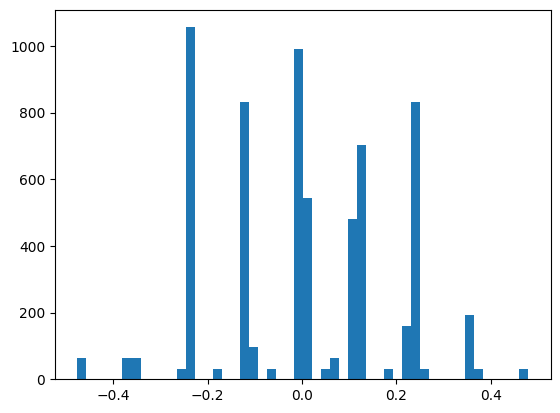

In [90]:
plt.hist(hpre.view(-1).tolist(),50)


<h3>Neurons Activity with Tanh Activation</h3>
<p>The tanh function maps inputs into the range [-1, 1]. Its derivative (gradient) vanish. White neurons show that they are dead(ineffective during learning because their gradient are nearly zero.)</p>

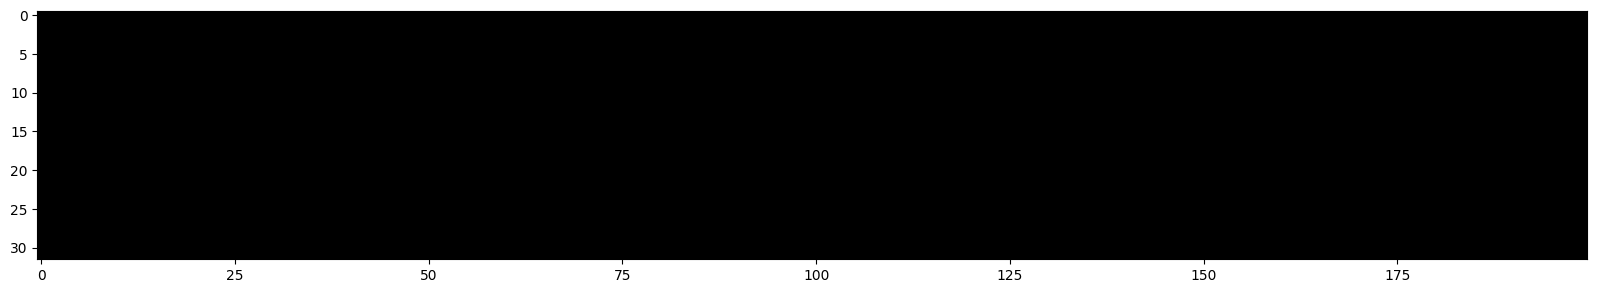

In [91]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest')